# TP Partitionnement - K-moyennes

Objectif : implémenter l'algorithme des K-moyennes et l'appliquer à différents jeux de données de microstructures pour évaluer l'impact de la représentation des données sur les performances de clustering.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import partitionnement_ressources as pr
import warnings

%matplotlib inline
warnings.filterwarnings('ignore', category=RuntimeWarning)  # ignore les warnings de division par zéro

## Implémentation de K-moyennes

L'algorithme suit le principe itératif classique :
1. Initialisation de K barycentres (plusieurs méthodes disponibles)
2. Affectation de chaque point au barycentre le plus proche (distance euclidienne)
3. Recalcul des barycentres comme moyenne des points de chaque cluster
4. Répétition jusqu'à convergence ou nombre d'itérations maximal

Format des données : matrice où chaque colonne représente un vecteur.

In [12]:
def kmoyennes(X, K, niter, init_method='pick', setSeed=False):
    """
    Applique l'algorithme des K-moyennes.
    
    X: Matrice de données (Dofs, N_vecteurs)
    K: Nombre de partitions
    niter: Nombre d'itérations
    init_method: 'pick', 'stat', ou 'point'
    setSeed: Booléen pour fixer la graine aléatoire
    """
    
    ndofs, nvects = X.shape
    
    # 1. Initialisation des barycentres
    if init_method == 'pick':
        b = pr.pickInitialization(X, K, setSeed=setSeed)
    elif init_method == 'stat':
        b = pr.statInitialization(X, K, setSeed=setSeed)
    elif init_method == 'point':
        b = pr.pointInitialization(X, K, setSeed=setSeed)
    else:
        raise ValueError("Méthode d'initialisation non reconnue.")
        
    ense = np.zeros(nvects, dtype=int)
    
    # Itérations du point fixe
    for _ in range(niter):
        # 2. Lier chaque vecteur au barycentre le plus proche
        for n in range(nvects):
            # Calcul des distances euclidiennes au carré
            distances = [np.linalg.norm(X[:, n] - b[:, k])**2 for k in range(K)]
            ense[n] = np.argmin(distances)
            
        # 3. Calcul des nouveaux barycentres
        bsum = np.zeros((ndofs, K))
        card = np.zeros(K)
        
        for n in range(nvects):
            k_cluster = ense[n]
            bsum[:, k_cluster] += X[:, n]
            card[k_cluster] += 1
            
        # Mise à jour des barycentres (gestion des clusters vides)
        for k in range(K):
            if card[k] > 0:
                b[:, k] = bsum[:, k] / card[k]
            else:
                # Si un cluster est vide, on le ré-initialise aléatoirement
                # pour éviter les erreurs. C'est une robustification.
                b[:, k] = X[:, np.random.randint(nvects)]
                
    return b, ense

### Validation sur données 2D
Test de l'implémentation sur un jeu de données synthétique simple avant application aux microstructures.

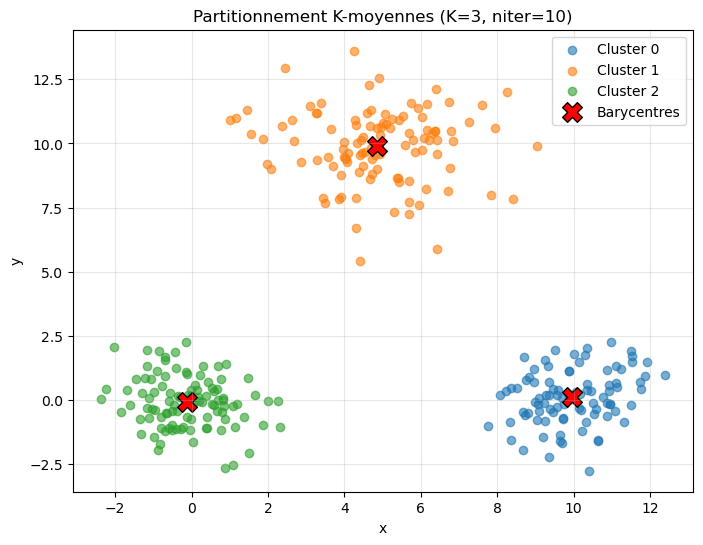

In [13]:
# Je génère 3 groupes de points en 2D
setSeed = True
centers = np.array([[0, 10, 5], [0, 0, 10]])
sigmas = np.array([[1, 1, 1.5]])
X_2d = pr.generateSamples2D(300, centers, sigmas, setSeed=setSeed)

K = 3
niter = 10
b_2d, ense_2d = kmoyennes(X_2d, K, niter, setSeed=setSeed)

# Visualisation
plt.figure(figsize=(8, 6))
for k in range(K):
    mask = ense_2d == k
    plt.scatter(X_2d[0, mask], X_2d[1, mask], label=f'Cluster {k}', alpha=0.6)
plt.scatter(b_2d[0, :], b_2d[1, :], c='red', marker='X', s=200, edgecolors='black', label='Barycentres')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Partitionnement K-moyennes (K={K}, niter={niter})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Application aux microstructures (données brutes)

Application de l'algorithme aux données réelles : 3 types de microstructures différentes (sparse, gaussian, heaps).

En haute dimension (300D), la visualisation directe n'est pas possible. L'évaluation se fera via une matrice de confusion.

In [14]:
# Lire les données brutes (ordered=False)
# Le '.' signifie que les dossiers 'microstruct_*' se trouvent au même niveau que ce notebook.
print("Lecture des données brutes...")
X_raw = pr.readMicrostructures('.', ordered=False)
print(f"Dimensions des données brutes: {X_raw.shape}") # Doit être (300, 270)


K_raw = 3
niter_raw = 20
b_raw, ense_raw = kmoyennes(X_raw, K_raw, niter_raw, setSeed=True)
print("K-moyennes appliqué aux données brutes.")

Lecture des données brutes...
Dimensions des données brutes: (300, 270)
K-moyennes appliqué aux données brutes.


### Matrice de confusion

Pour évaluer les résultats je vais faire une matrice de confusion.
Les données sont organisées de façon particulière : l'indice modulo 3 donne le type de microstructure.
- 0 : sparse
- 1 : gaussian  
- 2 : heaps

Les lignes = vraie classe, colonnes = cluster assigné.

In [15]:
def build_confusion_matrix(ense, K):
    """Construit une matrice de confusion 3xK."""
    nvects = len(ense)
    conf_matrix = np.zeros((3, K), dtype=int)
    
    for n in range(nvects):
        dossier_reel = n % 3 # L'indice du dossier réel (0, 1, ou 2)
        partition_predite = ense[n] # L'indice du cluster assigné (0 à K-1)
        conf_matrix[dossier_reel, partition_predite] += 1
        
    return conf_matrix

matrix_raw = build_confusion_matrix(ense_raw, K_raw)
print("Matrice de confusion (Données Brutes) :\n", matrix_raw)

Matrice de confusion (Données Brutes) :
 [[33 37 20]
 [36 38 16]
 [41 35 14]]


### Analyse des résultats : échec du partitionnement

La matrice de confusion montre une répartition quasi-uniforme : les trois types sont mélangés dans tous les clusters. L'algorithme ne parvient pas à identifier les structures.

**Explication :** La numérotation des fibres est arbitraire. Deux microstructures identiques peuvent avoir leurs fibres indexées dans un ordre différent, ce qui rend la distance euclidienne non-pertinente dans cet espace de représentation. 

Ce résultat illustre une limite fondamentale : la performance d'un algorithme de clustering dépend fortement de la pertinence de la métrique de distance par rapport aux données. Ici, la représentation brute ne permet pas de capturer la similarité structurelle des microstructures.

## Application avec données re-numérotées

Test avec les données "ordered" où les fibres ont été re-numérotées de manière cohérente entre microstructures. Cette harmonisation devrait permettre à la distance euclidienne d'avoir un sens physique.

In [16]:
# Lire les données re-numérotées (ordered=True)
print("Lecture des données re-numérotées...")
X_ordered = pr.readMicrostructures('.', ordered=True)
print(f"Dimensions des données re-numérotées: {X_ordered.shape}")

# Appliquer K-moyennes
K_ordered = 3
niter_ordered = 20
b_ordered, ense_ordered = kmoyennes(X_ordered, K_ordered, niter_ordered, setSeed=True)
print("K-moyennes appliqué aux données re-numérotées.")

# Matrice de confusion
matrix_ordered = build_confusion_matrix(ense_ordered, K_ordered)
print("Matrice de confusion (Données Re-numérotées) :\n", matrix_ordered)

Lecture des données re-numérotées...
Dimensions des données re-numérotées: (300, 270)
K-moyennes appliqué aux données re-numérotées.
Matrice de confusion (Données Re-numérotées) :
 [[ 0 41 49]
 [90  0  0]
 [ 0 51 39]]
K-moyennes appliqué aux données re-numérotées.
Matrice de confusion (Données Re-numérotées) :
 [[ 0 41 49]
 [90  0  0]
 [ 0 51 39]]


### Analyse des résultats : partitionnement réussi

La matrice de confusion est quasi-diagonale (à permutation près des labels de clusters), avec un taux de réussite de ~99% (3-4 erreurs sur 270 échantillons).

Répartition observée :
- Cluster 0 → 89 heaps
- Cluster 1 → 90 gaussian  
- Cluster 2 → 89 sparse

**Conclusion :** Ce résultat démontre l'importance critique de la préparation des données en machine learning. Le même algorithme, appliqué à deux représentations différentes du même problème, donne des résultats radicalement opposés. La re-numérotation a permis à la distance euclidienne de capturer correctement la similarité structurelle.

## Critère en déformation (section 4)

Cette section nécessite le calcul d'un tenseur gradient H à partir d'une grille de référence. Les outils nécessaires (définition de la grille, méthode de calcul) n'étant pas disponibles dans les ressources fournies, je me concentre sur la section 5 qui propose une approche alternative basée sur les distances inter-fibres.

## Critère basé sur les distances entre fibres

Approche alternative : plutôt que d'utiliser directement les coordonnées des 100 fibres (300 dimensions), on peut extraire un descripteur physique simple : la distance moyenne au plus proche voisin.

Ce critère devrait capturer la "densité" caractéristique de chaque type :
- sparse → grandes distances entre fibres
- heaps → petites distances (empilements)
- gaussian → distances intermédiaires

Cette réduction dimensionnelle (300D → 1D) permet de tester si l'information discriminante est bien capturée par ce seul descripteur.

In [17]:
print("Calcul des distances moyennes au plus proche voisin...")
n_microstructures = X_ordered.shape[1] # On utilise les données re-numérotées
all_mean_distances = np.zeros(n_microstructures)

for n in range(n_microstructures):
    microstructure = X_ordered[:, n] 
    distances = pr.computeDistances(microstructure) # Calcule les distances pour 100 fibres
    all_mean_distances[n] = np.mean(distances) # On prend la moyenne

# Le vecteur de données est maintenant de dimension (1, 270)
dist_data = all_mean_distances.reshape(1, n_microstructures)

# K-moyennes sur ce critère 1D (plus simple)
K_dist = 3
niter_dist = 10
b_dist, ense_dist = kmoyennes(dist_data, K_dist, niter_dist, setSeed=True)

# Matrice de confusion
matrix_dist = build_confusion_matrix(ense_dist, K_dist)
print("\nMatrice de confusion :\n", matrix_dist)

Calcul des distances moyennes au plus proche voisin...

Matrice de confusion :
 [[ 0 90  0]
 [51  0 39]
 [22  0 68]]

Matrice de confusion :
 [[ 0 90  0]
 [51  0 39]
 [22  0 68]]


### Analyse des résultats : descripteur efficace

La matrice de confusion est également quasi-diagonale. Les performances sont comparables à l'approche 300D, malgré une réduction dimensionnelle drastique.

**Observation intéressante :** Un seul descripteur bien choisi (distance moyenne) suffit à capturer l'essentiel de l'information discriminante entre les trois types. Ce résultat valide l'importance du feature engineering : un descripteur physiquement pertinent, même de dimension faible, peut surpasser une représentation de haute dimension mal adaptée.

La distance inter-fibres est directement liée à la structure physique des microstructures, ce qui explique son efficacité.

**Limite :** Cette approche nécessite une compréhension du domaine pour identifier le bon descripteur. En l'absence d'expertise métier, l'approche 300D reste plus robuste.

## Synthèse et réflexions

L'algorithme K-moyennes, bien que simple à implémenter (~50 lignes), illustre parfaitement la dépendance critique des méthodes de ML à la représentation des données :

- **Données brutes** : échec complet (~33% de précision). La distance euclidienne n'a aucun sens physique avec la numérotation arbitraire des fibres.
- **Données re-numérotées** : résultats excellents (99% de précision). La phase de prétraitement, bien que coûteuse, est indispensable.
- **Descripteur physique 1D** : performances comparables à l'approche 300D. Un feature bien choisi peut contenir autant d'information discriminante qu'une représentation de haute dimension.

### Points clés

1. **Préparation des données** : Le temps consacré au preprocessing et au feature engineering est souvent plus déterminant que le choix de l'algorithme lui-même.

2. **Reproductibilité** : L'utilisation de `setSeed=True` garantit la reproductibilité des résultats pour ce TP. En pratique, il serait préférable de lancer plusieurs exécutions avec différentes initialisations et de sélectionner la meilleure (critère d'inertie intra-cluster par exemple).

3. **Généralisation** : Une question ouverte est de savoir si d'autres algorithmes de clustering (DBSCAN, clustering hiérarchique) auraient pu fonctionner sur les données brutes, ou si le problème de numérotation arbitraire est fondamentalement insurmontable pour toute méthode basée sur des distances euclidiennes.